In [1]:
import numpy as np
from scipy.fft import fft2,ifft2,fftfreq,fftshift,ifftshift
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmath
from scipy.special import jn
import matplotlib.patches as patches

To see how light propagte throught a 1D object we can use fourier Optics.

In [2]:
def Optica(U0,X,Y,z,lamb):
    """
    Propagate a 2D optical field using the angular spectrum method.

    This function takes an initial field distribution in the XY-plane and 
    propagates it a distance `z` along the optical axis using Fourier methods.

    Args:
        U0 (ndarray, complex): 
            2D array representing the initial optical field (complex amplitude) 
            at z = 0, defined over the XY grid.
        X (ndarray, float): 
            2D meshgrid array of x-coordinates (same shape as U0).
        Y (ndarray, float): 
            2D meshgrid array of y-coordinates (same shape as U0).
        z (float): 
            Propagation distance along the optical axis.
        lamb (float): 
            Wavelength of the light (in the same units as X, Y, z).

    Returns:
        ndarray, complex:
            2D array of the propagated optical field at distance `z`, 
            with the same shape as `U0`.

    Notes:
        - Uses the angular spectrum method (Fourier optics). 
        - Handles evanescent components (where kx² + ky² > k²) by applying 
          an imaginary exponential decay.
        - Assumes uniform sampling in X and Y.
    """
    A = (fft2((U0)))
    Lx = np.max(abs(X))
    Ly= np.max(abs(Y))

    deltax = 2*Lx/len(U0)
    deltay = 2*Ly/len(U0)    


    fx = ( fftfreq(len(U0),deltax) )  
    fy = ( fftfreq(len(U0),deltay) )   
    
    #kx = ( fftfreq( len(X[0]), abs(X[0][0]-X[0][1])))C
    #ky = ( fftfreq(len(Y[0]), abs(Y[1][0]-Y[0][0])))
    
    Fx,Fy = np.meshgrid(fx,fy)
    K = 2*np.pi/lamb

    # Handle cases where u is negative
    u = K**2-(2*np.pi*Fx)**2-(2*np.pi*Fy)**2
    sqrt_u = 1j*z*np.sqrt(abs(u))
    sqrt_u[np.where(u<0)] = 1j*sqrt_u[np.where(u<0)]

    return  ( ifft2( ( A*np.exp(sqrt_u) ) ) )

In [5]:
def FigOptica(U0,X,Y,lamb,z,z0,n):
  """
    Propagate a 2D optical field through multiple distances and store the intensity along a central slice.

    Args:
        U0 (ndarray): Initial field mesh (2D array).
        X, Y (ndarray): Meshgrid arrays of x and y coordinates.
        lamb (float): Wavelength of light.
        z (ndarray): Array of propagation distances.
        z0 (ndarray): Array of incremental propagation distances for intermediate steps.
        n (int): Total number of steps for the propagation simulation.

    Returns:
        list: Intensities along the central line for all propagation steps.
    """
  ZX=[]

  # First half: fill with ones as placeholders
  for j in range(n//2):
    gg = z0[-1]*j
    for i in range(len(z0)): 
      ZX.append( np.ones(len(X[0])) )


  # Middle: include central slice of the initial field
  uu = U0.copy()
  uu[U0 == 0 ]= 3
  ZX.append( uu[len(uu)//2] )
  ZX.append( uu[len(uu)//2] )
  ZX.append( uu[len(uu)//2] )

  # Second half: propagate using Optica
  for j in range(n//2+1,n):
    gg = z0[-1]*j
    for i in range(len(z0)): 
      U = Optica(U0,X,Y,z0[i]+gg,lamb)
      ZX.append( abs(U[len(U0)//2])**2 )

  # Final propagation over main z array
  gg = (n)//2*(z0[-1] + abs(z[0]-z[1]))
  for i in range(len(z)):
    U = Optica(U0,X,Y,z[i]+gg,lamb)
    ZX.append(abs(U[len(U0)//2])**2)

    
  return ZX

In [6]:
N = 6*512#2**10
R= 12
x = np.linspace(-9*R,9*R,N,endpoint=False)
X,Y = np.meshgrid(x,x)
lamb = 0.632/1000

nn = len(x[abs(x)<1.2*R])
L = np.array([10,10])
zz = np.linspace(0,1800*R,nn)
z = np.arange(0,1800*R-20,abs(zz[0]-zz[1]))
# Scale of um
z0 = np.arange(0,L[0],abs(zz[0]-zz[1]))

# Initial field: circular aperture
U0_field = (X**2 + Y**2 > R**2).astype(float)

ZX = FigOptica(U0_field,X,Y,lamb,z,z0,2)


In [7]:
# High Resolution propagation for final frame
N = 7000#2**10

x0 = np.linspace(-9*R,9*R,N,endpoint=False)
X,Y = np.meshgrid(x0,x0)
U = Optica((X**2+Y**2>R**2).astype(float),X,Y,z[-40],lamb)

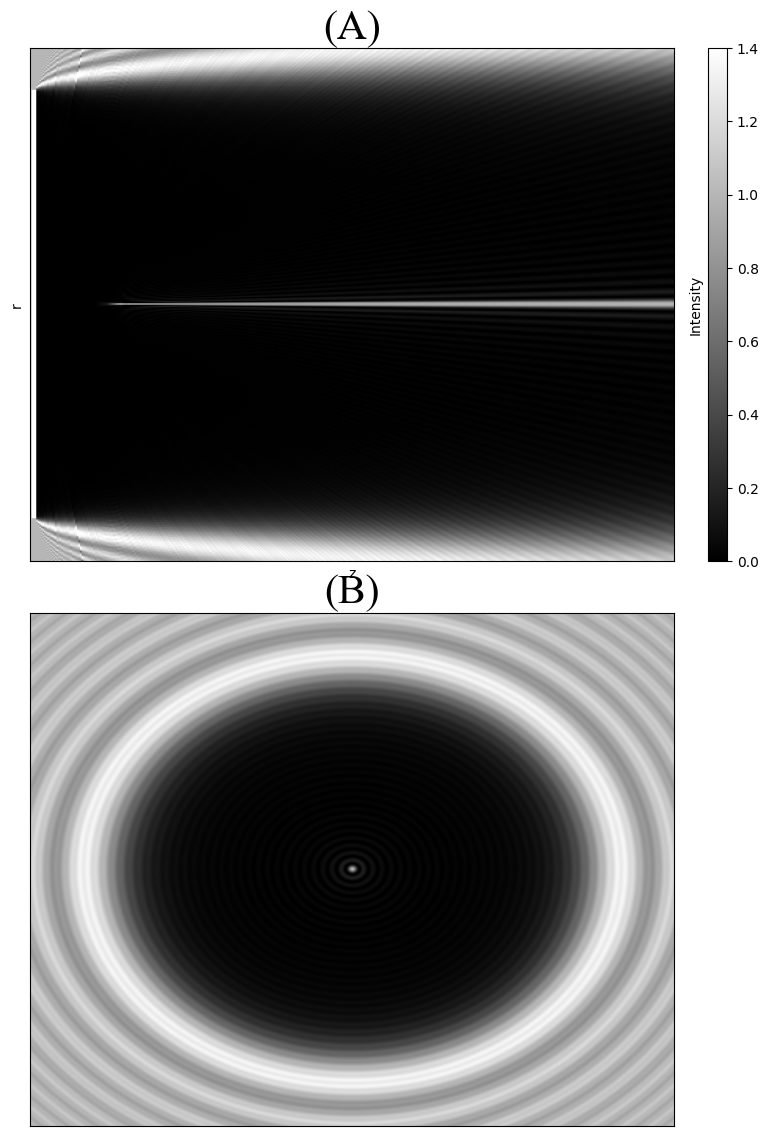

In [8]:
fig = plt.figure(figsize=(9,14))
gs = gridspec.GridSpec(2,2 ,width_ratios=[1,0.03],wspace=0.1,hspace=0.1)  # Adjust `wspace` to control space between columns

vmin,vmax =0 ,1.4
ax0 = fig.add_subplot(gs[0, 0])
img = ax0.imshow( np.transpose(ZX)[abs(x)<1.2*R] , cmap='gray' , aspect = 'auto', extent=[ -10,z[-1]+10,-1.2*R, 1.2*R],vmin=vmin,vmax=vmax)

ax0.set_ylabel(r'r')
ax0.set_yticks([])
ax0.set_xlabel('z')
ax0.set_xticks([])

ax0.set_title('(A)',fontname='Times New Roman', fontsize=30)



ax_cb = fig.add_subplot(gs[0, 1])
cbar = plt.colorbar(img, cax=ax_cb)
# Adjust the title (label) of the color bar
cbar.set_label("Intensity")  # Adjust the distance and position
cbar.ax.yaxis.set_label_position("left")  # Ensure the label is on the right side


ax0 = fig.add_subplot(gs[1, 0])
U0 = abs(U)**2

ax0.imshow(np.transpose(U0[abs(x0)<1.5*R])[abs(x0)<1.5*R], cmap = 'gray', aspect='auto',vmin=vmin,vmax=vmax)

ax0.set_yticks([])
ax0.set_xticks([])
#ax0.set_xticks([])


ax0.set_title('(B)',fontname='Times New Roman', fontsize=30)



plt.savefig('Analitico-rev.svg',dpi=300)